# Financial Inclusion by IndabaX Malawi-Anami Lok Citizens

![Financial Inclusion in Africa](https://www.caritas.org/wordpress/wp-content/uploads/2019/05/GeneralAssembly.jpg)

## Libraries Import

In [37]:
# !pip install -qr ../requirements.txt

In [1]:
import os 
import numpy as np 
import pandas as pd 
from zindi.user import Zindian
from catboost import CatBoostClassifier, Pool 
from category_encoders import CountEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from scipy.stats import mode
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

In [2]:
sorted(os.listdir("../Data"))

['SampleSubmission.csv',
 'Test.csv',
 'Train.csv',
 'VariableDefinitions.csv',
 'indabax-malawi-2021.zip']

## Read Data

In [3]:
ss, test, train, vd = [pd.read_csv(f"../Data/{f}") for f in sorted(os.listdir("../Data")) if f.endswith(".csv")]

## Little Data Exploration

In [4]:
ss.tail(5)

,unique_id,bank_account
33605,uniqueid_2998 x Uganda,0
33606,uniqueid_2999 x Uganda,0
33607,uniqueid_3000 x Uganda,0
33608,uniqueid_3001 x Uganda,0
33609,uniqueid_3002 x Uganda,0


In [5]:
test.tail(5)

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
10081,Uganda,2018,uniqueid_2998,Rural,No,2,62,Female,Spouse,Married/Living together,Primary education,Self employed
10082,Uganda,2018,uniqueid_2999,Urban,Yes,8,42,Male,Head of Household,Married/Living together,Primary education,Self employed
10083,Uganda,2018,uniqueid_3000,Urban,Yes,1,39,Male,Head of Household,Single/Never Married,Secondary education,Other Income
10084,Uganda,2018,uniqueid_3001,Rural,Yes,6,28,Female,Spouse,Married/Living together,Primary education,Self employed
10085,Uganda,2018,uniqueid_3002,Urban,Yes,7,16,Male,Other relative,Single/Never Married,Secondary education,Other Income


In [6]:
train.tail(5)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
23519,Uganda,2018,uniqueid_2113,No,Rural,Yes,4,48,Female,Head of Household,Divorced/Seperated,No formal education,Other Income
23520,Uganda,2018,uniqueid_2114,No,Rural,Yes,2,27,Female,Head of Household,Single/Never Married,Secondary education,Other Income
23521,Uganda,2018,uniqueid_2115,No,Rural,Yes,5,27,Female,Parent,Widowed,Primary education,Other Income
23522,Uganda,2018,uniqueid_2116,No,Urban,Yes,7,30,Female,Parent,Divorced/Seperated,Secondary education,Self employed
23523,Uganda,2018,uniqueid_2117,No,Rural,Yes,10,20,Male,Child,Single/Never Married,Secondary education,No Income


In [7]:
vd

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [8]:
train.columns.difference(test.columns)

Index(['bank_account'], dtype='object')

In [9]:
train.isna().sum()[train.isna().sum()!=0]

Series([], dtype: int64)

In [10]:
test.isna().sum()[test.isna().sum()!=0]

Series([], dtype: int64)

In [11]:
train.bank_account.value_counts()

No     20212
Yes     3312
Name: bank_account, dtype: int64

In [12]:
train.nunique()

country                      4
year                         3
uniqueid                  8735
bank_account                 2
location_type                2
cellphone_access             2
household_size              20
age_of_respondent           85
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

In [13]:
test.nunique()

country                      4
year                         3
uniqueid                  7313
location_type                2
cellphone_access             2
household_size              18
age_of_respondent           83
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

<AxesSubplot:>

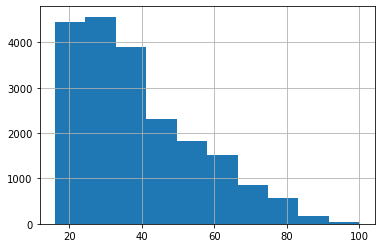

In [14]:
train.loc[train.bank_account=="No"].age_of_respondent.hist()

<AxesSubplot:>

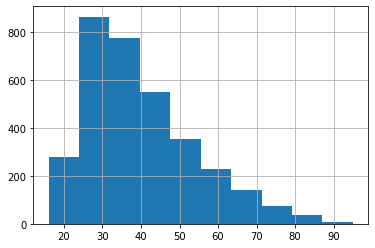

In [15]:
train.loc[train.bank_account=="Yes"].age_of_respondent.hist()

## Little Data Preparation

In [16]:
feature_names = list(train.columns.difference(["bank_account", "uniqueid"]))
print(sorted((feature_names)))

['age_of_respondent', 'cellphone_access', 'country', 'education_level', 'gender_of_respondent', 'household_size', 'job_type', 'location_type', 'marital_status', 'relationship_with_head', 'year']


In [17]:
train.country.unique(), test.country.unique()

(array(['Kenya', 'Rwanda', 'Tanzania', 'Uganda'], dtype=object),
 array(['Kenya', 'Rwanda', 'Tanzania', 'Uganda'], dtype=object))

In [18]:
train_group_ids=train.country
test_group_ids=test.country

In [19]:
train_subgroup_ids=train.uniqueid
test_subgroup_ids=test.uniqueid

In [20]:
train.year.unique(), test.year.unique()

(array([2018, 2016, 2017]), array([2018, 2016, 2017]))

In [21]:
train_group_weights=train.country.value_counts(normalize=True)#.apply(lambda x: 1-x)
train_group_weights.name="train_group_weights"

In [22]:
train_group_weights=train.join(train_group_weights, on="country")["train_group_weights"]

In [23]:
test_group_weights = test.country.value_counts(normalize=True)#.apply(lambda x: 1-x)
test_group_weights.name = "test_group_weights"

In [24]:
test_group_weights=test.join(test_group_weights, on="country")["test_group_weights"]

In [25]:
X=train[feature_names]
y=train.bank_account
X_test=test[feature_names]

In [26]:
# text_features=train.columns[-4:]

In [27]:
cat_features=X.select_dtypes("object").columns#.difference(text_features)
cat_features

Index(['cellphone_access', 'country', 'education_level',
       'gender_of_respondent', 'job_type', 'location_type', 'marital_status',
       'relationship_with_head'],
      dtype='object')

In [28]:
bank_account_mapper={"Yes":1, "No":0}
inverse_bank_account_mapper={1:"Yes", 0:"No"}

y=y.replace(bank_account_mapper)

y.value_counts()

X.year=X.year.apply(str)
X_test.year=X_test.year.apply(str)

X.household_size=X.household_size.apply(str)
X_test.household_size=X_test.household_size.apply(str)

# scaler=MinMaxScaler()

# X["age_of_respondent"]=scaler.fit_transform(X[["age_of_respondent"]])
# X_test["age_of_respondent"]=scaler.transform(X_test[["age_of_respondent"]])

## Train Function and utilities

In [29]:
skf = StratifiedKFold(random_state=2021, n_splits=5, shuffle=True)

def cat_predict(estimator,train,label,test,estimator_name):
    mean_train = []
    mean_test_val = []
    # test_pred = np.zeros(test.shape[0])
    test_pred=pd.DataFrame()
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
#         train_group_id, val_group_id = train_group_ids.iloc[train_index], train_group_ids.iloc[test_index]
#         train_group_weight, val_group_weight = train_group_weights.iloc[train_index], train_group_weights.iloc[test_index]
#         train_subgroup_id, val_subgroup_id = train_subgroup_ids.iloc[train_index], train_subgroup_ids.iloc[test_index]
        
        print(f'========================Fold{count +1}==========================')
        # estimator = clone(estimator)
        estimator.fit(Pool(x_train,y_train, feature_names=feature_names, 
#                            group_id=train_group_id, 
#                           subgroup_id=train_subgroup_id, 
#                            group_weight=train_group_weight, 
                           cat_features=cat_features,
#                            text_features=text_features
                          ), 
                      eval_set=[Pool(x_test,y_test, feature_names=feature_names, 
#                                      group_id=val_group_id,
#                                      subgroup_id=val_subgroup_id, 
#                                      group_weight=val_group_weight, 
                                     cat_features=cat_features,
#                            text_features=text_features
                                    )],early_stopping_rounds=200,
                           verbose=2500,use_best_model=True)
        train_predict = estimator.predict(Pool(x_train, y_train, feature_names=feature_names, 
#                                                group_id=train_group_id, 
#                                                subgroup_id=train_subgroup_id, 
#                                                group_weight=train_group_weight, 
                                               cat_features=cat_features,
#                            text_features=text_features
                                              )) 
        test_predict = estimator.predict(Pool(x_test, y_test, feature_names=feature_names, 
#                                               group_id=val_group_id, 
#                                               subgroup_id=val_subgroup_id, 
#                                               group_weight=val_group_weight, 
                                              cat_features=cat_features,
#                            text_features=text_features
                                             )) 
                                         
        val_pred[test_index] = test_predict.reshape(test_index.shape[0],)
        test_pred = pd.concat([test_pred, pd.Series(estimator.predict(Pool(test, feature_names=feature_names, 
#                           group_id=test_group_id, 
#                           subgroup_id=test_subgroup_ids,
#                           group_weight=test_group_weights, 
                           cat_features=cat_features,
#                            text_features=text_features
                            )).reshape(test.shape[0],), name=f"fold {count+1}")], axis=1)
        
        print('\nTesting scores', roc_auc_score(y_test,test_predict))
        print('\nTraining scores', roc_auc_score(y_train,train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test_val.append(roc_auc_score(y_test,test_predict))
    print('Average Testing ROC score for 5 folds split:',np.mean(mean_test_val))
    print('Average Training ROC score for 5 folds split:',np.mean(mean_train))
    print('standard Deviation for 5 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name

## Modelization

In [54]:
clf = CatBoostClassifier(random_state=34, use_best_model=True, 
                         n_estimators=400000, eval_metric='BalancedAccuracy',
                         class_weights = train.bank_account.value_counts(normalize=True,  dropna=False).sort_index().apply(lambda x: 1-x).values,
#                          cat_features=cat_features_indices,
#                          learning_rate=0.1,
#                          max_ctr_complexity=15,
#                          simple_ctr="Buckets",
#                          one_hot_max_size=25
                        )
cat1_train, cat1_test, cat1_name = cat_predict(clf,X, y, X_test,  'catboost(1)')

========================Fold1==========================
Learning rate set to 0.004829
0:	learn: 0.7382332	test: 0.7435091	best: 0.7435091 (0)	total: 25.8ms	remaining: 2h 52m 6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7846691564
bestIteration = 725

Shrink model to first 726 iterations.

Testing scores 0.78466915636197

Training scores 0.7843461774702675
========================Fold2==========================
Learning rate set to 0.004829
0:	learn: 0.7437115	test: 0.7408398	best: 0.7408398 (0)	total: 26.5ms	remaining: 2h 56m 53s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7770039771
bestIteration = 355

Shrink model to first 356 iterations.

Testing scores 0.7770039770942062

Training scores 0.7766447730126748
========================Fold3==========================
Learning rate set to 0.004829
0:	learn: 0.7417297	test: 0.7322374	best: 0.7322374 (0)	total: 35.1ms	remaining: 3h 54m 4s
Stopped by overfitting detector  (200 iterations w

## Evaluation

In [56]:
confusion_matrix(y, pd.Series(cat1_train).apply(int))#.value_counts()#.replace(inverse_bank_account_mapper)

array([[16388,  3824],
       [  834,  2478]])

In [57]:
print(classification_report(y, pd.Series(cat1_train).apply(int)))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88     20212
           1       0.39      0.75      0.52      3312

    accuracy                           0.80     23524
   macro avg       0.67      0.78      0.70     23524
weighted avg       0.87      0.80      0.82     23524



In [33]:
1-accuracy_score(y, pd.Series(cat1_train).apply(int))

0.19801054242475769

In [34]:
cat1_test.apply(lambda x: mode(x.values)[0][0], axis=1).replace(inverse_bank_account_mapper).value_counts()

No     7348
Yes    2738
dtype: int64

## Submission

In [35]:
test["bank_account"] = cat1_test.apply(lambda x: mode(x.values)[0][0], axis=1)#.replace(inverse_bank_account_mapper)

test["unique_id"]=test.uniqueid+ " x "+test.country

test[["unique_id", "bank_account"]].to_csv('../Submissions/baseline.csv', index=False)